In [1]:
from PIL import Image
import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from skimage import color

# Extraction de la dataset

In [2]:
from sklearn.utils import shuffle
targets = []
images = []

files1 = glob.glob("images/U/*.png")
files2 = glob.glob("images/P/*.png")

im_size = 28
#files = files1 + files2
# Mélanger les images
#random.shuffle(files)
# ajout des images dans et les resultats de test dans des tableau numpy
for file in files1:
    image = Image.open(file)
    #image = image.convert('LA')
    image = image.resize((im_size, im_size))
    image = np.array(image)
    images.append(image)
    target = 0
    targets.append(target)
    
for file in files2:
    image = Image.open(file)
    #image = image.convert('LA')
    image = image.resize((im_size, im_size))
    image = np.array(image)
    images.append(image)    
    target = 1
    targets.append(target)

images = np.array(images)  #image
targets = np.array(targets) # resultat 0 si pas malade et 1 si malade

# melanger les np.array
randomize = np.arange(len(images))
np.random.shuffle(randomize)
images = images[randomize]
targets = targets[randomize]

prof = images.shape[3]

targets_names = ["Uninfected","Parasitized"]

#afichage taille
print("shape features", images.shape)
print("shape targets", targets.shape)

shape features (27558, 28, 28, 3)
shape targets (27558,)


# Visualisation des images

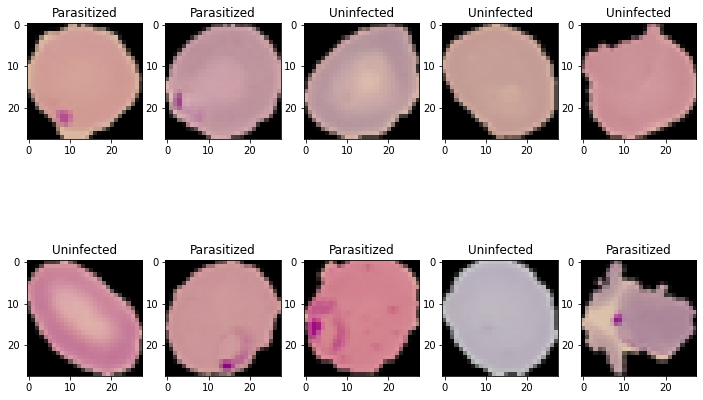

In [4]:
#affichage 10 images aléatoirement
from random import randint
plt.figure(figsize =(12,8))
p = 1
for a in [randint(0,len(targets)) for _ in range(10)]:
    plt.subplot(2,5,p)
    plt.imshow(images[a])
    p+=1
    plt.title(targets_names[targets[a]])
plt.show()

# séparation données d'apprentissage, validation, Test

In [5]:
images_train, images_test, targets_train, targets_test = train_test_split(images, targets, test_size = 0.20)

images_train, images_valid, targets_train, targets_valid = train_test_split(images_train, targets_train, test_size = 0.15)

print("shape images",images_train.shape)
print("shape targets", targets_train.shape )

shape images (18739, 28, 28, 3)
shape targets (18739,)


# Normalisation

In [6]:
print("mean", images_train.mean())
#scaled_images_train = tf.image.per_image_standardization(images_train)
#scaled_images_valid = tf.image.per_image_standardization(images_valid)

scaled_images_train = images_train/255
scaled_images_valid = images_valid/255
scaled_images_test = images_test/255

print("mean", scaled_images_train.mean())

print("shape", scaled_images_train.shape)


mean 120.03919181339221
mean 0.47074192867996895
shape (18739, 28, 28, 3)


# creaction dataset d'entraînement

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_train, targets_train))
valid_dataset = tf.data.Dataset.from_tensor_slices((scaled_images_valid, targets_valid))



# Parcout dataset

In [10]:
epoch = 1
batch_size = 10
for images_batch, targets_batch in train_dataset.repeat(epoch).batch(batch_size):
    print( targets_batch)
    break

tf.Tensor([0 0 1 0 0 1 1 0 1 0], shape=(10,), dtype=int64)


# Model à convolution

In [33]:
class ConvModel(tf.keras.Model):
    def __init__(self):
        super(ConvModel, self).__init__()
        #Convolutions
        self.conv1 = tf.keras.layers.Conv2D(32, (3,3), activation = "relu", name = "conv1")
        self.pool1 = tf.keras.layers.MaxPool2D(pool_size = (2,2))
        self.conv2 = tf.keras.layers.Conv2D(64, (3,3), activation = "relu", name = "conv2")
        self.pool2 = tf.keras.layers.MaxPool2D(pool_size = (2,2))
        self.conv3 = tf.keras.layers.Conv2D(128, (2,2), activation = "relu", name = "conv3")
        self.pool3 = tf.keras.layers.MaxPool2D(pool_size = (2,2))
        #self.conv4 = tf.keras.layers.Conv2D(256, (2,2), activation = "relu", name = "conv4")
        #self.pool4 = tf.keras.layers.MaxPool2D(pool_size = (2,2))
        #self.conv5 = tf.keras.layers.Conv2D(256, (3,3), activation = "relu", name = "conv5")
        #self.pool5 = tf.keras.layers.MaxPool2D(pool_size = (2,2))
        
        #flatten the convolution
        self.flatten = tf.keras.layers.Flatten(name = "flatten")
        # Dense layers
        self.d1 = tf.keras.layers.Dense(300, activation = "relu", name = "d1")
        self.dop1 = tf.keras.layers.Dropout(0.5)
        self.d2 = tf.keras.layers.Dense(300, activation = "relu", name = "d2")
        self.dop2 = tf.keras.layers.Dropout(0.5)

        #self.d3 = tf.keras.layers.Dense(100, activation = "relu", name = "d3")

        self.out = tf.keras.layers.Dense(2,activation = "softmax", name = "output")
    
    def call(self, image):
        conv1 = self.conv1(image)
        pool1= self.pool1(conv1)
        conv2 = self.conv2(pool1)
        pool2 = self.pool2(conv2)
        conv3 = self.conv3(pool2)
        pool3 = self.pool3(conv3)
        #print(pool3)
        #conv4 = self.conv4(pool3)
        #pool4 = self.pool4(conv4)
        #conv5 = self.conv5(pool4)
        #pool5 = self.pool4(conv5)
        flatten = self.flatten(pool3)
        d1 = self.d1(flatten)
        dop1 = self.dop1(d1)
        d2 = self.d2(dop1)
        #d3 = self.d3(d2)
        dop2 = self.dop2(d2)
        output = self.out(dop2)
        return output
        
model = ConvModel()
model.predict(scaled_images_train[0:1])
#scaled_images_train[0:1].shape

array([[0.47359762, 0.5264024 ]], dtype=float32)

In [34]:
#model.summary()

# Definition d'une fonction de perte et un optimiseur

In [35]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Metrics

In [36]:
#loss
train_loss = tf.keras.metrics.Mean(name = "train_loss")
valid_loss = tf.keras.metrics.Mean(name = "valid_loss")
#accuracy
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = "train_accuracy")
valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name = "valid_accuracy")

# Méthode d'Entraînement du model 

In [37]:
#utilisation du mode graph
@tf.function
def train_step(image, targets):
    with tf.GradientTape() as tape:
        #prediction sur l'image
        predictions = model(image)
        # capture de l'erreur comise sur la prediction
        loss = loss_object(targets, predictions)
    #calcul du gradient
    gradients = tape.gradient(loss, model.trainable_variables)
    #modification des poids en fonction du  gradient
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    #accumulation metrics
    train_loss(loss)
    train_accuracy(targets, predictions)

# Validation

In [38]:
@tf.function
def valid_step(image, targets):
    predictions = model(image)
    t_loss = loss_object(targets, predictions)
    valid_loss(t_loss)
    valid_accuracy(targets, predictions)

# Entraînement

In [39]:
Epoch = 5
batch_size = 30
b = batch_size
acc_cuve = []
loss_cuve = []
acc_valid_cuve = []
loss_valid_cuve = []
for epoch in range(Epoch):
    valid_loss.reset_states()
    valid_accuracy.reset_states()
    train_loss.reset_states()
    train_accuracy.reset_states()
    
    #Entrainement
    for images_batch, targets_batch in train_dataset.batch(batch_size):
        train_step(images_batch, targets_batch)
        b += batch_size
    acc_cuve.append(train_accuracy.result())
    loss_cuve.append(train_loss.result())
    template = "\r Batch {}/{}, Loss: {}, Accuracy: {}"
    print(template.format(
    b, (epoch+1)*len(train_dataset), train_loss.result(), train_accuracy.result()*100
    ))
    
       
        #Validation
    for images_batch, targets_batch in valid_dataset.batch(batch_size):
        valid_step(images_batch, targets_batch)
    
    acc_valid_cuve.append(valid_accuracy.result())
    loss_valid_cuve.append(valid_loss.result())
    template = "Epoch {}, Valid loss: {}, valid accuracy {}"
    print(template.format(
    epoch +1, valid_loss.result(), valid_accuracy.result()*100
    ))
    
    


 Batch 18780/18739, Loss: 0.3827662467956543, Accuracy: 81.39175415039062
Epoch 1, Valid loss: 0.19236518442630768, valid accuracy 93.74055480957031
 Batch 37530/37478, Loss: 0.17416706681251526, Accuracy: 94.13522338867188
Epoch 2, Valid loss: 0.22198523581027985, valid accuracy 93.74055480957031
 Batch 56280/56217, Loss: 0.14957775175571442, Accuracy: 95.05843353271484
Epoch 3, Valid loss: 0.17508193850517273, valid accuracy 94.6779556274414
 Batch 75030/74956, Loss: 0.1374908983707428, Accuracy: 95.51203155517578
Epoch 4, Valid loss: 0.184789776802063, valid accuracy 94.70819091796875
 Batch 93780/93695, Loss: 0.13145944476127625, Accuracy: 95.69880676269531
Epoch 5, Valid loss: 0.15947431325912476, valid accuracy 95.01058197021484


In [40]:
g=5
#scaled_images_train0 = scaler.fit_transform(images_valid[g:g+1].reshape(-1,im_size*im_size))
#scaled_images_train0 = scaled_images_train0.reshape(-1,im_size,im_size,prof)
scaled_images_train0 = scaled_images_valid[g:g+1]
#images[0].shape
#scaled_images_train[0].shape
#print(model.predict(scaled_images_train0))
prev =  model.predict(scaled_images_train0)
print(prev)
print(targets_names[np.argmax(prev)])
print(targets_valid[g])

[[9.9979776e-01 2.0229004e-04]]
Uninfected
0


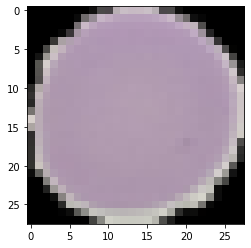

In [41]:
plt.imshow(images_valid[g])

# Matrice de convusion sur les données de Test

In [42]:
from sklearn.metrics import confusion_matrix
prev =  model.predict(scaled_images_test)
prev = np.argmax(prev, axis = 1)
conf = confusion_matrix(targets_test,prev)
print(conf)
#print(targets_valid)

[[2706   63]
 [ 217 2526]]


# Courbes d'apprentissage

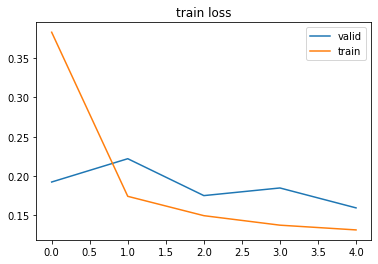

In [43]:
plt.title('train loss')
plt.plot(loss_valid_cuve, label = 'valid')
plt.plot(loss_cuve, label = 'train')
plt.legend()
plt.show()


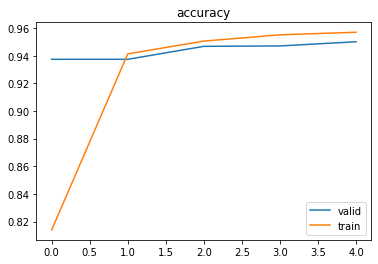

In [44]:
plt.title('accuracy')
plt.plot(acc_valid_cuve, label = 'valid')
plt.plot(acc_cuve, label = 'train')
plt.legend()
plt.show()


# Sauvegarde du model

In [45]:
model.save("cnn_malaria")


INFO:tensorflow:Assets written to: cnn_malaria/assets


# Charger le model 

In [11]:
restored = tf.keras.models.load_model("cnn_malaria")